# Trabajo Práctico 1 
### Clasificación sobre datos simulados. 

## Introducción
Para este trabajo, hemos creado una función generadora de minions. Sobre cada minion, hemos medido 200 características que representan habilidades que poseen en distintas tareas (relacionadas al Mal).  

El doctor Nefario ha ideado una fórmula para determinar si un minion es o no apto para concretar su plan para conquistar el mundo. De esta manera ha etiquetado más de 500 minions. Lamentablemente, ha perdido dicha fórmula y necesita seguir decidiendo si nuevos minions son o no aptos para su macabro plan.

Es por esto que nuestro objetivo será construir clasificadores que estimen lo mejor posible la probabilidad de que nuevos minions sean o no aptos para concretar el plan de conquista y así facilitarle las cosas al doctor Nefario.

Por otra parte, ya que el doctor Nefario tuvo problemas con equipos que sobreestiman sus resultados, decidió guardarse varias etiquetas extra que no compartirá con nadie, y que luego utilizará para elegir al mejor equipo, al cual contratará para (de una vez por todas) conquistar el mundo. 


En concreto:

Tendrán disponible una matriz de datos $X$ de $500$ filas en donde cada fila $x^{(i)}$ representa un vector de $200$ características de cada instancia. Es decir, $\textbf{x}^{(i)} = x_1^{(i)}, \dots, x_{200}^{(i)}$ con $i$ entre $1$ y $500$. Además, tendrán y, un vector de $500$ posiciones con dos posibles valores: $True$ y $False$. 

Por otra parte, tendrán disponibles más instancias de evaluación $X_{competencia}$ sin las respectivas etiquetas que utilizaremos para evaluar sus resultados. 



In [1]:
# PREAMBULOS
%matplotlib inline

SEED = 1234

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from IPython.display import display, HTML
from time import time

import numpy as np
np.set_printoptions(precision=4)
np.random.seed(SEED)

import pandas as  pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)
pd.set_option('precision', 4)

import matplotlib.pyplot as plt

import seaborn as sns

import sklearn.ensemble

from scipy.stats import randint as sp_randint

In [2]:
# Carga de datos
X = pd.read_csv("X.csv", index_col="index")
y = pd.read_csv("y.csv", index_col="index", dtype=int)  # Cargamos los valores booleanos (True y False)
                                                        # como números (1 y 0) para facilitar el manejo luego. 
    
X_competencia = pd.read_csv("X_competencia1.csv", index_col="index")
y_competencia_ejemplo = pd.read_csv("y_competencia_ejemplo.csv", index_col="index")
#display(X)
#display(y)

# Descomentar si quieren ver los datos para la competencia:
# display(X_competencia) 
# display(y_competencia_ejemplo)

## Ejercicio 1

### Separación de datos

Contarán con una cantidad limitada de datos, por lo cual es importante tomar una buena decisión en el momento de empezar a utilizarlos. En este punto pedimos que evalúen cómo separar sus datos para desarrollo y para evaluación tomando en cuenta la competencia.

X_dev: (450, 200), y_dev: (450, 1) para desarrollo
X_eval: (50, 200), y_eval: (50, 1) para evaluación


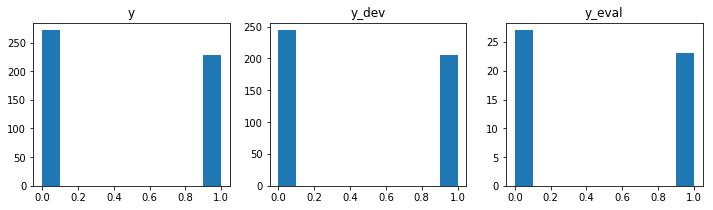

In [3]:
# EJERCICIO 1. 

import sklearn.model_selection

np.random.seed(666)


########################################################
# Objetivo: variables X_dev, X_eval, y_dev e y_eval asignadas

X_dev, X_eval, y_dev, y_eval = sklearn.model_selection.train_test_split(X, y, test_size=0.1, shuffle=True, stratify=y)

#########################################################


print("X_dev: {}, y_dev: {} para desarrollo".format(X_dev.shape, y_dev.shape))
print("X_eval: {}, y_eval: {} para evaluación".format(X_eval.shape, y_eval.shape))

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title('y')
plt.hist(np.array(y))  # muestra un histograma para la distribución de y.
plt.subplot(132)
plt.title('y_dev')
plt.hist(np.array(y_dev))  # muestra un histograma para la distribución de y_dev.
plt.subplot(133)
plt.title('y_eval')
plt.hist(np.array(y_eval))  # muestra un histograma para la distribución de y_eval.
plt.show()

Suponemos y asumimos que el dataset con el que contamos tiene una distribución representativa de la distribución poblacional real, y por lo tanto estratificamos la separación de los datos para desarrollo y held-out.
Funciones utilizadas posteriormente, como por ejemplo GridSearchCV, proceden a estratificar los datos por default. Conservar datos como held-out nos brindará una referencia para medir la performance de nuestros futuros modelos para la competencia.

## Ejercicio 2

### Construcción de modelos

Para este punto, la tarea consiste en construir y evaluar modelos de tipo árbol de decisión, de manera de obtener una estimación realista de la performance de los mismos. 

1. Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default. 
2. Estimar la performance del modelo utilizando K-fold cross validation con K = 5, con las métricas “Accuracy” y “ROC AUC”. Para ello, se pide medir la performance en cada partición tanto sobre el fold de validación como sobre los folds de entrenamiento. Luego, completar la primera tabla.
3. Entrenar árboles de decisión para cada una de las siguientes combinaciones y completar la segunda tabla.

----

**EJERCICIO EXTRA:** Usar la implementación de árboles de decisión que realizaron para la guía de ejercicios de la materia. Adaptarla para que cumpla con la interfaz requerida por sklearn, asegurarse de que funcione con variables continuas y reproducir las tablas anteriores.

----

,Accuracy (training),Accuracy (validación),AUC ROC (training),AUC ROC (validación)
0,0.8301,0.7033,0.8795,0.7126
1,0.8194,0.6556,0.8837,0.6565
2,0.8500,0.6667,0.9003,0.7153
3,0.8472,0.5889,0.8942,0.5976
4,0.8310,0.7978,0.8712,0.8194


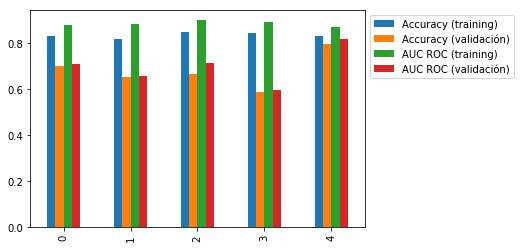

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from arbol import MiClasificadorArbol
accuracies_training = []
accuracies_validation = []
aucs_training = []
aucs_validation = []

# Puede serles de utilidad tener a X_dev e y_dev como matrices de numpy directamente:
X_dev_np = np.array(X_dev)
y_dev_np = np.array(y_dev).ravel()


########################################################
## Objetivo: accuracies_training, accuracies_validation, aucs_training y aucs_validation asignados

tree = DecisionTreeClassifier(max_depth=3)

scores = cross_validate(tree, X_dev, y_dev, scoring=["roc_auc", "accuracy"], return_train_score=True, cv=5)
tabla1 = pd.DataFrame(scores)

accuracies_training = tabla1[['train_accuracy']]
accuracies_validation = tabla1[['test_accuracy']]
aucs_training = tabla1[['train_roc_auc']]
aucs_validation = tabla1[['test_roc_auc']]

#########################################################

df = pd.DataFrame(index=range(0,5))
#df.index.name = "Permutación"
                  
df["Accuracy (training)"] = accuracies_training
df["Accuracy (validación)"] = accuracies_validation
df["AUC ROC (training)"] = aucs_training
df["AUC ROC (validación)"] = aucs_validation


display(HTML("<h3> TABLA 1 </h3>"))
display(df)

# Descomentar las siguientes líneas para graficar el resultado
df.plot(kind="bar")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

,Accuracy (training),Accuracy (validación),AUC ROC (training),AUC ROC (validación)
0,1.0,0.80,1.0,0.7802
1,1.0,0.55,1.0,0.5220
2,1.0,0.75,1.0,0.7500
3,1.0,0.75,1.0,0.7500
4,1.0,0.65,1.0,0.6500


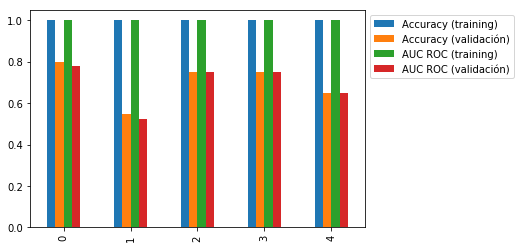

In [5]:
from arbol import MiClasificadorArbol
accuracies_training = []
accuracies_validation = []
aucs_training = []
aucs_validation = []

# Puede serles de utilidad tener a X_dev e y_dev como matrices de numpy directamente:
X_dev_short = np.array(X_dev.head(100))
y_dev_short = np.array(y_dev.head(100)).ravel()


########################################################
## Objetivo: accuracies_training, accuracies_validation, aucs_training y aucs_validation asignados

tree = MiClasificadorArbol()

scores = cross_validate(tree, X_dev_short, y_dev_short, scoring=["roc_auc", "accuracy"], return_train_score=True, cv=5)
tabla1 = pd.DataFrame(scores)

accuracies_training = tabla1[['train_accuracy']]
accuracies_validation = tabla1[['test_accuracy']]
aucs_training = tabla1[['train_roc_auc']]
aucs_validation = tabla1[['test_roc_auc']]

#########################################################

df = pd.DataFrame(index=range(0,5))
#df.index.name = "Permutación"
                  
df["Accuracy (training)"] = accuracies_training
df["Accuracy (validación)"] = accuracies_validation
df["AUC ROC (training)"] = aucs_training
df["AUC ROC (validación)"] = aucs_validation


display(HTML("<h3> TABLA 1 </h3>"))
display(df)

# Descomentar las siguientes líneas para graficar el resultado
df.plot(kind="bar")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

resultados_training = []
resultados_validation = []

########################################################
## Objetivo: resultados_training y resultados_validation asignadas

param_grid = {'criterion' : ('gini', 'entropy'), 'max_depth' : (3, 5, None)}

gs = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring="roc_auc",
                  n_jobs=-1, cv=5, return_train_score=True)
gs.fit(X_dev, y_dev)
tabla2 = pd.DataFrame(gs.cv_results_)

resultados_training = tabla2[['mean_train_score']]
resultados_validation = tabla2[['mean_test_score']]

#########################################################

df = pd.DataFrame(index=range(0,6))

df["Altura máxima"] = [3, 5, "Inifinito"] * 2
df["Criterio de evaluación de corte"] = ["Gini"] * 3 + ["Ganancia de Información"] * 3
df["AUC ROC Promedio en Training"] = resultados_training
df["AUC ROC Promedio en Validación"] = resultados_validation


display(HTML("<h3> TABLA 2 </h3>"))
display(df)
print('Mejores Parámetros', gs.best_params_)

Ya sea utilizando tanto Gini ó Entropia como criterio de corte para el árbol de decisiones, se puede apreciar que al aumentar el parámetro de altura máxima el puntaje promedio de entrenamiento aumenta pero esta tendencia no se ve respaldada por los puntajes obtenidos en validación, un claro caso de overfitting

## Ejercicio 3: Comparación de algoritmos


Se pide explorar distintas combinaciones de algoritmos de aprendizaje e hiperparámetros, de manera de buscar una performance óptima. Para este ejercicio es necesario que evalúen posibilidades utilizando la técnica de Grid Search. Como métrica de performance, usar siempre el área bajo la curva (AUC ROC) resultante de 5-fold cross-validation. 

Algoritmos a probar: KNN, árboles de decisión, LDA, Naive Bayes y SVM. Hiperparámetros: Revisar la documentación de cada uno para la búsqueda de combinaciones prometedoras.  

Se pide generar un reporte que contenga: 

1. Una descripción de las distintas combinaciones consideradas y su performance asociada (las que consideren relevantes, con al menos la mejor combinación para cada algoritmo). 

1. Una breve explicación de los factores que creen que produjeron dicho resultado. 

En este punto evaluaremos tanto los hiperparámetros elegidos como las conclusiones relacionadas a por qué piensan que ciertos algoritmos funcionan mejor que otros para estos datos. 



----

**EJERCICIO EXTRA**: Utilizar RandomizedSearchCV con rangos de parámetros que contengan a los utilizados en el GridSearch. Analizar si se encontraron mejores combinaciones de parámetros que no hayan sido tenidas en cuenta con el GridSearch y cuál fue la diferencia de tiempo de ejecución. 

----

Antes de comenzar procedemos a realizar un preprocesamiento de nuestros datos para adaptarlos correctamente a los requirimientos de las hipotesis de cada algoritmo.

La estandarización de los datos implica, para cada feature por separado, restar la media para centrar en cero y dividir para la varianza para normalizar en función de esta. Mientras que el re-escalado transforma el rango de valores de cada feature proporcionalmente entre 0 y 1.

Algoritmos como Naive Bayes suelen verse beneficiados por este preprocesamiento de los datos demostrando una mejor performance, mientras que otros como Support Vector Machine (en especial con su su kernel radial basis function, RBF) asumen que los datos ya se encuentran en este formato y resulta por lo tanto un requerimiento.

In [ ]:
# Standarization
from sklearn.preprocessing import StandardScaler
X_dev_std = StandardScaler().fit_transform(X_dev_np)

from sklearn.preprocessing import minmax_scale
X_dev_minmax = minmax_scale(X_dev_np)

# Resampleo
from sklearn.utils import resample
X_rs, y_rs = resample(X_dev_std, y_dev, n_samples=500)
X_rs = np.array(X_rs)
y_rs = np.array(y_rs).ravel()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score


## Si quieren, pueden utilizar esta función para imprimir las mejores combinaciones de su grid
def top_resultados(grid, top=5):
    print("Top {} Combinaciones".format(top))
    df = pd.DataFrame(grid.cv_results_["params"])
    df["AUC ROC Promedio en Training"] = grid.cv_results_["mean_train_score"]
    df["AUC ROC Promedio en Validacion"] = grid.cv_results_["mean_test_score"]
    display(df.sort_values(by="AUC ROC Promedio en Validacion", ascending=False).head(top))


def print_results(grid_search, title, X_eval, y_eval):
    print(title)
    top_resultados(grid_search, top=5)
    print("Parametros elegidos: {}".format(grid_search.best_params_))
    print("Mejor AUC ROC: {:.4f}".format(grid_search.best_score_))
    print("AUC ROC obtenido en Held On: {:.4f}\n".format(roc_auc_score(y_eval, grid_search.predict(X_eval))))
    
########################################################
## Objetivo: comparar y explorar distintas combinaciones de parámetros para los algoritmos importados arriba

# K-Nearest Neighbors
# (n_neighbors, weights, algorithm, leaf_size, p, metric, metric_params, n_jobs)

param_grid = {'n_neighbors': [1, 5, 10, 15, 20, 25, 30, 35, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
              'weights': ['uniform', 'distance'],
              # 'algorithm': ['ball_tree', 'kd_tree', 'brute'], # esto no modifica mucho
              'p': [1, 2]
             }
gs = GridSearchCV(KNeighborsClassifier(), param_grid, scoring="roc_auc", cv=5, n_jobs=-1).fit(X_dev, y_dev_np)
knn_model = gs.best_estimator_
print_results(gs, "K-Nearest Neighbors", X_eval, y_eval)


# Scaled K-Nearest Neighbors
# (n_neighbors, weights, algorithm, leaf_size, p, metric, metric_params, n_jobs)
gs = GridSearchCV(KNeighborsClassifier(), param_grid, scoring="roc_auc", cv=5, n_jobs=-1).fit(X_dev_std, y_dev_np)
print_results(gs, "K-Nearest Neighbors STD", X_eval, y_eval)


# Scaled K-Nearest Neighbors just uniform
# (n_neighbors, weights, algorithm, leaf_size, p, metric, metric_params, n_jobs)
gs = GridSearchCV(KNeighborsClassifier(),
                  {'n_neighbors': [1, 5, 10, 15, 20, 25, 30, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44], 'p': [1, 2]},
                  scoring="roc_auc", cv=5, n_jobs=-1).fit(X_rs, y_rs)
print_results(gs, "K-Nearest Neighbors STD con Peso Uniforme y Diferentes Funciones de Distancia", X_eval, y_eval)

# Linear Discriminant Analysis
# (solver, shrinkage, priors, n_components, store_covariance, tol)
param_grid = {'solver': ['svd', 'lsqr', 'eigen']}
gs = GridSearchCV(LinearDiscriminantAnalysis(), param_grid, scoring="roc_auc", cv=5, n_jobs=-1
                 ).fit(X_dev, y_dev_np)
print_results(gs, "Linear Discriminant Analysis", X_eval, y_eval)

# Decision Tree
# (criterion, splitter, max_depth, min_samples_split, min_samples_leaf, min_weight_fraction_leaf, max_features,
# random_state, max_leaf_nodes, min_impurity_decrease, min_impurity_split, class_weight, presort)
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}
gs = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring="roc_auc", cv=5, n_jobs=-1).fit(X_dev, y_dev_np)

print_results(gs, "Decision Tree", X_eval, y_eval)
tree_best_params = gs.best_params_


# Gaussian Naive Bayes
true_ratio = np.sum(y_dev_np) / y_dev_np.size
param_grid = {'priors': [[1-true_ratio, true_ratio], [0.1, 0.9],[0.4, 0.6],[0.5, 0.5],[0.6, 0.4], [0.9, 0.1]]}
nb_estimator = GaussianNB()
grid_search = GridSearchCV(nb_estimator, param_grid, scoring="roc_auc", cv=5).fit(X_dev_np, y_dev_np)
#grid_search = GridSearchCV(nb_estimator, param_grid, scoring="roc_auc", cv=5, n_jobs=-1).fit(X_rs, y_rs)
print_results(grid_search, "Gaussian Naive Bayes", X_eval, y_eval)


# Support Vector Classification con entrada estandarizada
# (C, kernel, degree, gamma, coef0, shrinking, probability, tol, cache_size,
# class_weight, verbose, max_iter, decision_function_shape, random_state)
svc_params_gamma = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
svc_params_c = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100] 
param_grid = {
    'C': svc_params_c,
    'kernel': ["linear", "poly", "rbf", ],#"sigmoid"],
    'gamma': svc_params_gamma
}
gs = GridSearchCV(SVC(), param_grid, scoring="roc_auc", cv=5, n_jobs=-1).fit(X_dev_std, y_dev_np)
print_results(gs, "Support Vector Classification STD", X_eval, y_eval)
svc_best_params = gs.best_params_


## Conclusiones Grid Search

### K Nearest Neighbors
Realizamos una busqueda para los parámetros *cantidad de vecinos*, la función *peso* para la influencia de cada vecino en la decisión final, y el parámetro *p* que establece qué definición de distancia se utilizará. Cuando el peso del vecino se define por la inversa de la distancia (aquellos más cercanos son mas significativos), el ajuste sobre los datos de entrenamiento alcanza una predicción perfecta, típico indicador de un posible overfitting. En cambio, cuando se utiliza un peso *uniforme*, se observa una ligera disminución en los puntajes de entrenamiento pero con puntajes de validación similares y más próximos entre si. Esto significa que estos modelos con peso uniforme presentan una baja varianza.
Dada la naturaleza geométrica del algoritmo, decidimos probar estandarizando los datos de entrada. Comprobamos un puntaje similar en validación aunque una leve mejora en el puntaje del modelo sobre el held-out. También, al realizar una búsqueda local y fijar el peso en *uniforme*, encontramos mejorías en este sentido.

### Arbol de decisión
Completamos el analisis hecho en el punto anterior con otros valores para el parámetro max_depth en el rango de 1 a 7 e infinito. Pese a que nuestros datos cuentan con una cantidad grande de features los mejores árboles tienen una altura máxima de 3 o 4. Con una altura de 5 ya vemos que el modelo "overfittea" de entrenamiento (0.97) y comienza a empeorar con los datos de validación. Esta es una característica propia de este algoritmo: no es muy util contar con un solo árbol muy profundo.

### Naive Bayes
Este algoritmo no es muy parametrizable. Decidimos entonces probar como afectaba cambiar las probabilidades a priori. Calculamos una aproximación de acuerdo a la proporcion en el dataset de entrenamiento y despues completamos con probabilidades complementarias entre 0 y 1. La busqueda con grid search muestra que no hubo variacion y todos los modelos tienen el mismo rendimiento con cualquier probabilidad a priori que le definamos.
Los resultados no son muy buenos ni para los datos de entrenamiento (rondando los 0.85) pero vemos que estos puntajes son muy cercanos a los de validación. Este resultado sugiere que nuestros modelos tienen un sesgo alto pero una varianza baja. Esto se puede deber a que el algoritmo utilizado asume fuertemente que la distribución de los datos es gaussiana.

### LDA
Cambiar el método de cómputo de la matriz de covarianza no modificó los resultados obtenidos.

### Support vector machines

Varíamos los parámetros *c*, *gamma* y el tipo de kernel. De este último hiperparámetro parece haber consenso en que RBF es el que mejor funciona para nuestro problema. Dado que SVM sufre con datos muy dispersos, alimentamos el modelo cambiando la escala de los datos de entrenamiento. Es destacable que con este modelo obtuvimos el mejor puntaje para la partición held-out. Probablemente una posterior busqueda focalizada con paso más fino podría incrementar el puntaje. 

## Ejercicio 4: 
### Diagnóstico Sesgo-Varianza. 

En este punto, se pide inspeccionar dos de sus mejores modelos encontrados hasta ahora: el mejor modelo de tipo árbol de decisión y el mejor de tipo SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo, variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo RandomForest con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos (usar  grid search para encontrar una buena combinación de parámetros).  


**Atención**: Tener en cuenta que debemos seguir utilizando ROC AUC como métrica para estas curvas.

**ver**: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

----
**EJERCICIO EXTRA:** Utilizar RandomizedSearchCV para explorar la performance del algoritmo de Gradient Boosting y comparar con los resultados obtenidos en el punto (c).


----




In [ ]:
from sklearn.model_selection import validation_curve
def print_validation_curve(title, param_range, train_scores, test_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.title('Curva de validación ' + title)
    plt.xlabel(title)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Puntaje Promedio en Training", color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Puntaje Promedio en Validación",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    #plt.show()

def print_validation_curve_log(title, param_range, train_scores, test_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.title('Curva de validación ' + title)
    plt.xlabel(title)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Puntaje Promedio en Training", color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Puntaje Promedio en Validación",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")    

In [ ]:
plt.figure(figsize=[14, 5])

# Arbol
estimator = DecisionTreeClassifier().set_params(**tree_best_params)

# Altura
param_range = [1, 2, 3, 4, 5, 6, 7, 10]
train_scores, test_scores = validation_curve(estimator, X_dev_np, y_dev_np, param_name="max_depth", 
                                             param_range=param_range, cv=10,
                                             scoring="roc_auc", n_jobs=-1)

plt.subplot(121)
print_validation_curve('max_depth', param_range, train_scores, test_scores)
plt.ylim(0.5, 1.1)


param_range = [3, 6, 10, 20, 30]
train_scores, test_scores = validation_curve(estimator, X_dev_np, y_dev_np, param_name="max_depth", 
                                             param_range=param_range, cv=10,
                                             scoring="roc_auc", n_jobs=-1)

plt.subplot(122)
print_validation_curve('max_depth', param_range, train_scores, test_scores)
plt.ylim(0.5, 1.1)


plt.show()

### Curva de validación - Árbol de decisión
En el primer gráfico vemos que para un valor de 3 en la altura máxima del arbol se alcanza un máximo en el puntaje. En este valor la varianza no es muy grande. Luego, a partir de un valor de 6, el sesgo hacia los datos de entrenamiento se vuelve muy grande y los modelos comienzan a dar peores resultados.

En el segundo gráfico analiza los valores sucesivos a mayor escala donde vemos que, aproximadamente a partir de un valor de altura de 10, el puntaje se comporta de manera asintótica y el algoritmo nunca presenta una mejora.


In [ ]:
### SVC
plt.figure(figsize=[14, 5])
print("Support Vector Machine")

# Gamma
plt.subplot(121)

estimator = SVC().set_params(**svc_best_params)
param_range = svc_params_gamma
train_scores, test_scores = validation_curve(estimator, X_dev_std, y_dev_np, param_name="gamma", 
                                             param_range=param_range, cv=5, scoring="roc_auc", n_jobs=-1)

print_validation_curve_log("$\gamma$", param_range, train_scores, test_scores)
plt.ylim(0.3, 1.1)
# C
plt.subplot(122)

estimator = SVC().set_params(**svc_best_params)
param_range = svc_params_c
train_scores, test_scores = validation_curve(estimator, X_dev_std, y_dev_np, param_name="C", 
                                             param_range=param_range, cv=5, scoring="roc_auc", n_jobs=-1)
print_validation_curve_log('C', param_range, train_scores, test_scores)
plt.ylim(0.7, 1.1)
plt.show()


### Curvas de validación - Support Vector Machines

En la curva de validación del parámetro _C_ vemos que con un valor superior o igual a 1 la varianza aumenta. En ese valor la curva de validación alcanza su máximo. Luego el sesgo hacia los datos de entrenamiento aumenta, lo cual es consistente con lo que representa el parámetro _C_. Valores grandes de _C_ minimizan el margen entre el hiperplano y los vectores soporte, mientras que valores pequeños resultan en un hiperplano con margenes grandes, con la posibilidad de clasificar mal algunas instancias.


In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Puntaje")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, 
                                                            train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Puntaje Promedio en Training")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Puntaje Promedio en Validación")
    plt.legend(loc="best")
    return plt


plt.figure(figsize=[16,3])
plt.subplot(131)
print("Árbol de Decisiones - Parametros: {}".format(tree_best_params))
title = "Árbol de Decisiones - Curvas de Aprendizaje"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = DecisionTreeClassifier().set_params(**tree_best_params)

plot_learning_curve(estimator, title, X_dev_np, y_dev_np, ylim=(0.5, 1.01), cv=cv, n_jobs=-1)


plt.subplot(132)


print("SVM - Parametros: {}".format(svc_best_params))
title = "SVM - Curvas de Aprendizaje"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC().set_params(**svc_best_params)

plot_learning_curve(estimator, title, X_dev_np, y_dev_np, ylim=(0.5, 1.01), cv=cv, n_jobs=-1)

plt.subplot(133)
# Naive Bayes
plot_learning_curve(grid_search.best_estimator_, 'Naive Bayes - Curvas de Aprendizaje', X_dev_np, y_dev_np, ylim=(0.0, 1.01), cv=cv, n_jobs=-1)


plt.show()

### Curvas de aprendizaje

Mediante las curvas de aprendizaje podemos determinar si el modelo se veria beneficiado por agregado de más muestras para entrenamiento. Si tanto el puntaje de validación como el puntaje de entrenamiento convergen hacia un valor bajo, entonces al aumentar el tamaño del set con el cual se realiza el entrenamiento no repercutiría significativamente en los resultados obtenidos. Tanto Naive Bayes como SVM al parecer ya se estabilizaron y su performance no parece mejorar con el agregado de nuevas muestras. En cambio, el algoritmo de árbol de decisiones muestra una pendiente creciente indicando una posible mejora al contar con un conjunto de entrenamiento mayor al actual

3) Construir un modelo RandomForest con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos (usar  grid search para encontrar una buena combinación de parámetros).  

In [ ]:
from sklearn.ensemble import RandomForestClassifier


random_forest_model = RandomForestClassifier(n_estimators=200, max_depth=None,min_samples_split=2, n_jobs=-1)

#Buscamos hiperparametros con grid search
param_grid = {'max_features': np.arange(6, 25,1),
              'n_estimators': [10, 100, 110, 200],
              'max_depth': [3, 5, None],
              'min_samples_split': [2, 3, 5]
             }

grid_search = GridSearchCV(
    random_forest_model, param_grid, scoring="roc_auc", cv=5, n_jobs=-1).fit(X_dev_np, y_dev_np)
print_results(grid_search, 'Random Forest', X_eval, y_eval)
random_forest_model = grid_search.best_estimator_


#param_range = ['auto', 'sqrt', 'log2']
#estimator = RandomForestClassifier(max_depth=None,min_samples_split=2, n_jobs=-1)
#param_range = np.linspace(10, 200, 10, dtype=int)

plt.figure(figsize=[14,8])
#param_range = np.linspace(0.1, 0.4, 9)
param_range = [7, 14, 15, 44, 74, 100, 200]
train_scores, test_scores = validation_curve(random_forest_model, X_dev_np, y_dev_np,
                                             param_name="max_features", param_range=param_range,
                                             cv=10, n_jobs=-1)
plt.subplot(221)
print_validation_curve('max_features', param_range, train_scores, test_scores)
plt.ylim(0.6, 1.1)

param_range = np.arange(6, 25,1)
train_scores, test_scores = validation_curve(random_forest_model, X_dev_np, y_dev_np,
                                             param_name="max_features", param_range=param_range,
                                             cv=10, n_jobs=-1)
plt.subplot(222)
print_validation_curve('max_features', param_range, train_scores, test_scores)
plt.ylim(0.6, 1.1)



#param_range = [10, 100, 110, 200, 300, 400]
#train_scores, test_scores = validation_curve(random_forest_model, X_dev_np, y_dev_np,
#                                             param_name="n_estimators", param_range=param_range,
#                                             cv=10, n_jobs=-1)

#plt.subplot(223)
#print_validation_curve('n_estimators', param_range, train_scores, test_scores)
#plt.ylim(0.6, 1.1)

plt.show()



El parámetro *max_features* representa la cantidad de features con los que va a disponer el algoritmo a la hora de dividir cada nodo. El hecho de tener un subconjunto elegido al azar en cada nodo es lo que provee de aleatoriedad al algoritmo y produce que todos los arboles sean distintos entre si.
La bibliografía sugiere valores cercanos a la raiz cuadrada (14) o al log_2 (7) del total de features (200).

La busqueda devuelve que los mejores parámetros son:
- altura: indefinida. Esto es consistente con la teoría. Los arboles del bosque deben ser altos para ser diferentes entre si y aportar información distinta entre si.

- max_features: 7. El valor coincide con el logaritmo en base 2 del total de features. Sin embargo, en las curvas de validación vemos que no hay mucha variabilidad al cambiar este parámetro. Tanto en la busqueda general como en la local (con valores pequeños entre 6 y 25) vemos que los puntajes se mueven entre 0.7 y 0.8. Esto puede significar que los modelos no se están beneficiando de la aleatoriedad de los árboles y que nuestro problema, nuestros datos, tampoco tienen esa característica.

- n_estimators: 110. En esta y otras pruebas obsevamos que a partir del valor 100 o 110 en la cantidad de árboles el algoritmo deja de mejorar.

- min_samples_split: 3. Este parámetro controla la cantidad mínima en que debe dividirse un nodo. La búsqueda no provee resultados concluyentes para afirmar que un valor es mejor que otro. Los resultados son bastante parecidos.


El puntaje de la mejor combinación de parámetros en held-out no es muy bueno en comparacion con los modelos que estudiamos anteriormente. Tambien vemos que los mejores resultados de la búsqueda muestran un sobreajuste en los datos de prueba y un puntaje (0.85) bastante alejado para las instancias de validación.

In [ ]:
plt.figure(figsize=[16, 5])
plt.subplot(121)
plot_learning_curve(
    random_forest_model,
    'Curva de aprendizaje Random Forest',
    X_dev_np, y_dev_np, 
    ylim=(0.6, 1.01), cv=cv, n_jobs=-1)
plt.show()

La curva de aprendizaje muestra una mejoría, tenue pero clara, a medida que aumentan las instancias de prueba. Esto nos sugiere que sí sería útil contar con mas instancias de entrenamiento.

## Competencias

La entrega del trabajo estará acompañada de una competencia en la cual deberán poner a prueba su mejor modelo y sobre todo, su capacidad para estimar sus resultados. 

Su tarea será estimar la performance (AUC ROC) que tendrá su mejor modelo en datos de evaluación (X_competencia). 

Para ello, deberán predecir las probabilidades de las distintas instancias con su modelo, enviarnos dichas probabilidades junto a una estimación con 4 decimales de cuál será el AUC ROC resultante y calcularemos el resultado real. El grupo que consiga acercarse más al valor real, será el grupo ganador.  

Recomendamos no perder de vista esta competencia en el momento de separar los datos en los primeros puntos. 

Para esto, junto con la entrega del informe, deberán enviar un archivo en formato csv con las columnas “index” y “output” (ver ejemplo de archivo en: [y_competencia_ejemplo.csv](https://github.com/pbrusco/aa-notebooks/blob/master/TP1/y_competencia_ejemplo.csv)) y un valor esperado de AUC ROC. 


## Entrega
- Contarán con un esqueleto en formato Jupyter Notebook en donde tendrán que completar las celdas faltantes (ya sea con explicaciones y gráficos o código). 
- El notebook final deberá ser entregado en formatos .html e .ipynb. Es necesario que los resultados puedan reproducirse al ejecutar todas las celdas en orden (Kernel - Restart and Run All) utilizando las bibliotecas requeridas en el archivo: requirements.txt del repositorio. 
- Tienen tiempo hasta las 23:59hs del día miércoles 17/10/2018. La entrega se debe realizar a través del campus virtual y debe contener el informe.
- El trabajo deberá elaborarse en grupos de 3 personas.
- Se podrán pedir pruebas de integridad y autoría; es decir, verificar que la salida solicitada es fruto del modelo presentado y que el modelo fue construido según lo requerido en este enunciado.
- La evaluación será grupal y se basará en la calidad del informe (presentación, claridad, prolijidad); la originalidad, practicidad y coherencia técnica de la solución; la corrección y solidez de las pruebas realizadas.
- En el primer parcial se incluirá una pregunta sobre la solución entregada. Esa pregunta no influirá en la nota del parcial, pero sí en la nota individual del TP1.
- La participación en la competencia es obligatoria. De todas maneras, el resultado no incidirán en la nota de la materia.
- Los ejercicios extra son opcionales para aprobar el TP, pero son obligatorios para promocionar la materia.


## Estratégia para la Competencia

Según lo conversado en clase, será declarado ganador de la competencia aquel grupo que mejor pueda predecir su propio desempeño. Por lo tanto, lo importante no es focalizar la atención en alcanzar un gran puntaje en validación o en la partición held-out, sino en elegir aquel modelo que muestre la mayor consistencia en todos los resultados, es decir la menor diferencia entre todas sus evaluaciones.

De los modelos ensayados, el algoritmo KNN con *cantidad de vecinos* alrededor de 40 y *peso uniforme* fue el que mostró estas caracteristicas.

Como dijimos al comienzo, si suponemos que el dataset con el que contamos tiene una distribución representativa de la distribución poblacional real, al utilizar un modelo con algoritmo KNN que utilice como parámetro de *vecinos cercanos* un número suficientemente grande (próximo ó más grande que la muestra a predecir en si), y como una función de *peso* el criterio *uniforme*, la predicción para cada instancia sería el de la mayoria con un porcentaje de acierto posiblemente cercano a los porcentajes de tal distribución. Siguiendo esta estrategia, incluso se podria configurar una función random con probabilidad equivalente a dicha distribución y se obtendrian resultados similares. Sin embargo, al no tener certeza sobre nuestra suposición es probable que esta táctica pueda ser erronea.